packages are imported

In [1]:
from google.colab import drive  # For mounting Google Drive
import zipfile  # For handling zip files
import os  # For file and directory operations
import pandas as pd  # For data manipulation with DataFrames
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For data visualization
import cv2  # For image processing
from sklearn.preprocessing import LabelEncoder  # For encoding labels
from tensorflow.keras.preprocessing.image import (  # For image loading and processing
    load_img,
    img_to_array,
    ImageDataGenerator,
)
from tensorflow.keras.models import Sequential  # For building sequential models
from tensorflow.keras.layers import (  # For adding layers to the model
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
)
from tensorflow.keras.utils import to_categorical  # For categorical conversion
from tensorflow.keras.optimizers import Adam, SGD  # For optimizers
from tensorflow.keras.callbacks import EarlyStopping  # For early stopping during training
from keras.layers import BatchNormalization
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.models import Model
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


Google collab is mounted into my googledrive to access the datafiles.

In [2]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to the main zip file in Google Drive
main_zip = "/content/drive/My Drive/Colab Notebooks/Leaf Data/leaf-classification.zip"

# Extract the main zip file
with zipfile.ZipFile(main_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/leaf_data")

# Extract nested zips: images.zip, train.csv.zip, test.csv.zip, sample_submission.csv.zip
nested_zips = ['images.zip', 'train.csv.zip', 'test.csv.zip', 'sample_submission.csv.zip']

for z in nested_zips:
    with zipfile.ZipFile(f"/content/leaf_data/{z}", 'r') as zip_ref:
        zip_ref.extractall("/content/leaf_data")

# Verify the extracted files
!ls /content/leaf_data


Mounted at /content/drive
images	    sample_submission.csv      test.csv      train.csv
images.zip  sample_submission.csv.zip  test.csv.zip  train.csv.zip


The train and test data CSV files are loaded into the session. They layout of the data is checked to ensure the data was loaded properly. The shape of the data was also obtained to ensure all of the data was loaded in.

In [3]:

# Load train and test CSVs
train = pd.read_csv("/content/leaf_data/train.csv")
test = pd.read_csv("/content/leaf_data/test.csv")

# Display basic information
print(train.head())
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# Check columns to ensure they are loaded in correctly
print(train.columns)



   id                species   margin1   margin2   margin3   margin4  \
0   1            Acer_Opalus  0.007812  0.023438  0.023438  0.003906   
1   2  Pterocarya_Stenoptera  0.005859  0.000000  0.031250  0.015625   
2   3   Quercus_Hartwissiana  0.005859  0.009766  0.019531  0.007812   
3   5        Tilia_Tomentosa  0.000000  0.003906  0.023438  0.005859   
4   6     Quercus_Variabilis  0.005859  0.003906  0.048828  0.009766   

    margin5   margin6   margin7  margin8  ...  texture55  texture56  \
0  0.011719  0.009766  0.027344      0.0  ...   0.007812   0.000000   
1  0.025391  0.001953  0.019531      0.0  ...   0.000977   0.000000   
2  0.003906  0.005859  0.068359      0.0  ...   0.154300   0.000000   
3  0.021484  0.019531  0.023438      0.0  ...   0.000000   0.000977   
4  0.013672  0.015625  0.005859      0.0  ...   0.096680   0.000000   

   texture57  texture58  texture59  texture60  texture61  texture62  \
0   0.002930   0.002930   0.035156        0.0        0.0   0.004883  

Here we define our image directory to be called upon in the code.

A list called "missing_items" is created that will store any image ids that are not found in the image folder. After running this chucnk we are given confirmation that all our images are accounted for.

In [4]:

# Define the directory where images are stored
image_dir = "/content/leaf_data/images"  # Adjust this path to your training images directory



# Step 2: Check for the presence of images in the directory
missing_images = []
for img_id in train['id']:
    img_path = os.path.join(image_dir, f"{img_id}.jpg")  # Adjust this if images have a different extension
    if not os.path.exists(img_path):
        missing_images.append(img_id)

if missing_images:
    print(f"Missing images for IDs: {missing_images}")
else:
    print("All images found.")

All images found.


A function "visualize_images" is defined. This function loads and displays some imaged from the image folder and labels them with their appropriate species class. This gives a good visualization of the images the CNN will attempt to classify. This also ensures that the images are being loaded into the session correctly.

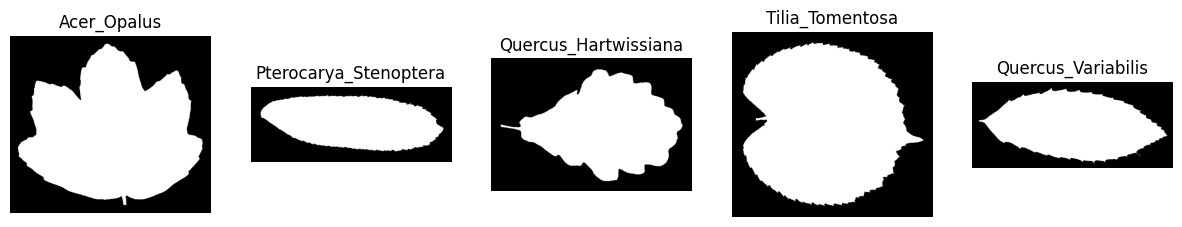

In [5]:
# Step 3: Visualize images
def visualize_images(df, image_dir, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        img_id = df.iloc[i]['id']
        img_path = os.path.join(image_dir, f"{img_id}.jpg")  # Adjust based on your image format
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(df.iloc[i]['species'])
        plt.axis('off')
    plt.show()

# Visualize images
visualize_images(train, image_dir)


In order for our model to match the images in the image folder to the classification listed in the training csv, the .jpg needed to be added to the end of all the image IDs in the CSV file. The images are named with the ID number in a jpg format. This process is reversed for the testing IDs when the submission CSV is being created.

A label encoder is used to encode the species class to integers 0-98 (99 classes). One hot encoding was attempted but yeilded worse results than traditional encoding (loss socres out about .9).

To ensure we have 99 classes encoded, I added a print statement.

In [6]:
# Add the image extension to the id column for CNN model identification
train['id'] = train['id'].astype(str) + '.jpg'

# Encode Labels (we have 99 species of leafs that must be encoded) - not using one-hot encoding
label_encoder = LabelEncoder()
train['species_encoded'] = label_encoder.fit_transform(train['species'])

# Display the number of classes to ensure there is 99
num_classes = len(np.unique(train['species_encoded']))
print(f"Number of classes: {num_classes}")



Number of classes: 99


A datagen is created to load in the images for use in the CNN model. In the datagen, the pixel values of the images are rescaled to follow a distribution from 0-1 instead of the original 0-255 format. This will prevent our model from having to perform math functions on very large numbers and helps standardize the data. A validation set containing 20% of the data is created.

For the most part, data augmentation was not used. Exploring the images, there was no zoom, shear, brightness differences, etc., so image augmentation would not be useful for this model. However, it was discovered that some of the images were horizontally flipped from others (the stem ends could be on both the left and right sides). Due to this observation, horizontal flip was enabled, but vertical flip was not.

In [7]:
# Define the ImageDataGenerator for training and validation with rescaling and augmentations
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2,  # 20% of the data will be used for validation
    horizontal_flip=True,   # Enable horizontal flip
    vertical_flip=False,     # Enable vertical flip
)


Train and valiation generators were created. The image directory is called, x is defined as the image ID, target variable is defined as species, images are rescaled to fit 128x128 pixels, batch size is 16, sparse clas mode is used becuase one hot encoding was not used, shuffle is set to true, and seed is set for reproducability.

Originally batch size was set to 32, resulting in 25 batches in the training data. I found that a batch size of 16 helped the model perform better, as each epoch was allowed 50 weight updates. With the limited number of training samples compared to class numbers (only about 10 training images per class) I decided that more weight updates per epoch was necessary.

In [8]:

# Define ImageDataGenerator for training with only rescaling
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=image_dir,
    x_col='id',
    y_col='species',  # Keep this as the original labels
    target_size=(128, 128),
    batch_size=16,
    class_mode='sparse',  # Change to 'sparse' to use sparse categorical crossentropy - becuase we are not using one hot encoding
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=image_dir,
    x_col='id',
    y_col='species',
    target_size=(128, 128),
    batch_size=16,
    class_mode='sparse',  # Change to 'sparse'
    subset='validation',
    shuffle=True,
    seed=42
)


Found 792 validated image filenames belonging to 99 classes.
Found 198 validated image filenames belonging to 99 classes.


The commented out model below was my first raw model. The purpose was to make a simple model that would take the data and train fast to get formatting down and assess the usefulness of a CNN model for this problem. The model was semi-successful, with the best log loss score achieved in the high .5s. This basic model performed better than XGBoost, showing the power of CNN models in image analysis.

In [9]:
# Build the CNN model
#model = Sequential()
#model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Flatten())
#model.add(Dense(512, activation='relu'))  # Additional Dense layer
#model.add(Dropout(0.5))  # Add Dropout for regularization
#model.add(Dense(256, activation='relu'))  # Additional Dense layer
#model.add(Dropout(0.3))  # Add Dropout for regularization
#model.add(Dense(128, activation='relu'))  # Additional Dense layer
#model.add(Dropout(0.2))  # Add Dropout for regularization
#model.add(Dense(num_classes, activation='softmax'))  # Output layer

#model.summary()


In [10]:
# Compile the model with Adam optimizer
#model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Set up EarlyStopping
#early_stopping = EarlyStopping(
 #   monitor='val_loss',  # Metric to monitor
 #   patience=3,          # Number of epochs with no improvement after which training will be stopped
#    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
#)

# Train the model with Adam optimizer for the first 5 epochs
#initial_epochs = 50
#history = model.fit(
 #   train_generator,
 #   epochs=initial_epochs,
 #   validation_data=validation_generator,
 #   callbacks=[early_stopping]  # Include EarlyStopping in callbacks
#)

# Change to SGD optimizer for further training
#model.compile(optimizer=SGD(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with SGD optimizer for additional epochs
#additional_epochs = 50  # You can change this value as needed
#history_sgd = model.fit(
 #   train_generator,
 #   epochs=additional_epochs,
 #   validation_data=validation_generator,
 #   callbacks=[early_stopping]  # Include EarlyStopping in callbacks
#)

The chunk below defines the model.
The input shape for the model is 128x128x3 pixels. And class number is 99.

I import the VGG16 model and use the pre-trained weights to start, making them trainable.

I add a deep layer of 256 neurons with the ReLU activation function, batch normalization, and 20% dropout. I found considerable improvement when using batch normalization. Attempts with combinations of 128, 256, 512, and 1024 neuron deep layers utilizing batch sizes of 32 and 16 as well as different dropout rates and enabling and disabling batch normalization were tested with the best and most consistent results below.

The model is trained with the Adam optimizer for the first 50 epochs and fine tuned with the SDG optimizer for the next 50 epochs. An early stopper is used to stop training if validation loss does not improve over 5 consecutive epochs, while storring the weights for the best achieved model.

In [12]:

# Define constants
input_shape = (128, 128, 3)  # Input shape for the images
num_classes = 99  #99 classes/species of leaves

# Build the base model - importing VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Build the complete model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu')) #add one one dense layer
model.add(BatchNormalization()) #normalizes the output of the dense layer
model.add(Dropout(0.2)) #randomly dropping 20% of the neurons during each iteration to prevent overfitting
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with Adam optimizer
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Set up EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, #stops if val_loss does not improve over 5 epochs
    restore_best_weights=True
)

# Set up ModelCheckpoint
checkpoint = ModelCheckpoint(
    'best_model_vgg16.keras',  # Save model as .keras file
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',  # Save only the best model based on validation accuracy
    verbose=1  # Print messages when saving
)


# Train the model with Adam optimizer
initial_epochs = 50
history_adam = model.fit(
    train_generator,
    epochs=initial_epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint]
)

# Recompile the model with the SGD optimizer
model.compile(optimizer=SGD(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with SGD optimizer for additional epochs
additional_epochs = 50
history_sgd = model.fit(
    train_generator,
    epochs=additional_epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, checkpoint]
)



58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.1690 - loss: 4.1410
Epoch 1: val_accuracy improved from -inf to 0.15152, saving model to best_model_vgg16.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 185ms/step - accuracy: 0.1735 - loss: 4.1133 - val_accuracy: 0.1515 - val_loss: 4.0114
Epoch 2/50
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6689 - loss: 1.7914
Epoch 2: val_accuracy improved from 0.15152 to 0.46970, saving model to best_model_vgg16.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6695 - loss: 1.7860 - val_accuracy: 0.4697 - val_loss: 2.3103
Epoch 3/50
48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8113 - loss: 1.0788
Epoch 3: val_accuracy improved from 0.46970 to 0.66162, saving model to best_model_vgg16.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.8128 - loss: 1.0735 - val_accuracy: 0.6616 - val_loss: 1.4993
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9003 - loss: 0.6331
Epoch 4: val_accuracy improved from 0.

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 99)                  │          25,443 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,838,565 (64.23 MB)

 Trainable params: 2,123,363 (8.10 MB)

 Non-trainable params: 14,715,200 (56.13 MB)

 Optimizer params: 2 (12.00 B)

The function below creates graphs of validation accuracy and validation log loss as training progresses. As you can see, the adam optimizer is achieving fast training with larger weight adjustments and SDG is fine tuning the model.

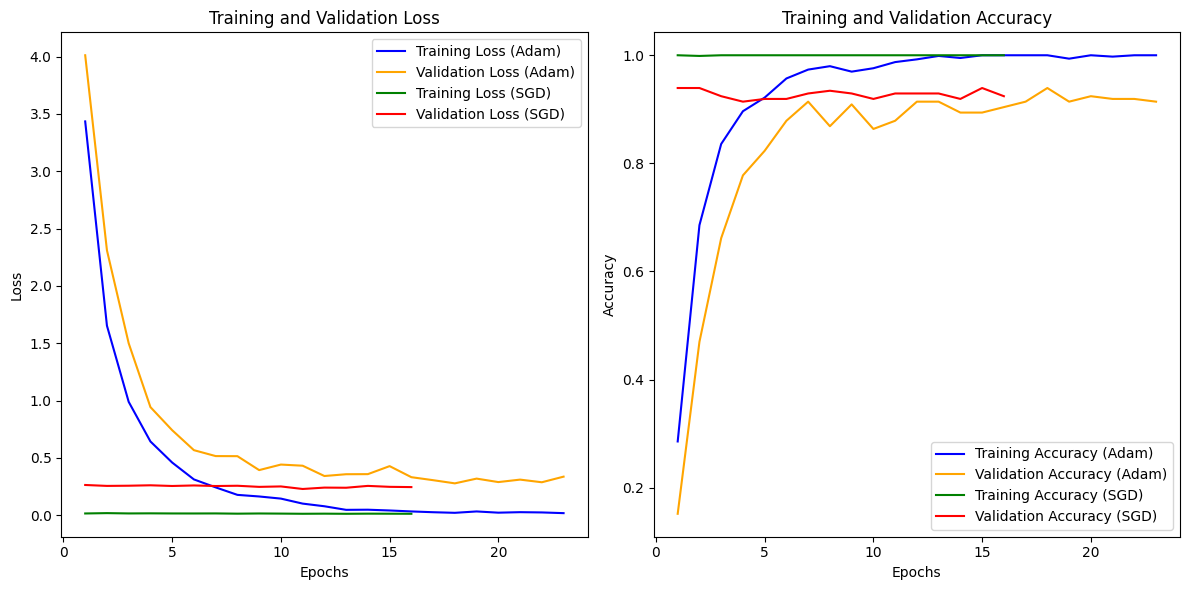

In [14]:
import matplotlib.pyplot as plt

#Define a function to plot validation accuracy and loss metrics over the training period
def plot_metrics(history_adam, history_sgd):
    # Extract metrics from the history objects
    loss_adam = history_adam.history['loss']
    val_loss_adam = history_adam.history['val_loss']
    accuracy_adam = history_adam.history['accuracy']
    val_accuracy_adam = history_adam.history['val_accuracy']

    loss_sgd = history_sgd.history['loss']
    val_loss_sgd = history_sgd.history['val_loss']
    accuracy_sgd = history_sgd.history['accuracy']
    val_accuracy_sgd = history_sgd.history['val_accuracy']

    # Calculate the number of epochs
    epochs_adam = range(1, len(loss_adam) + 1)
    epochs_sgd = range(1, len(loss_sgd) + 1)

    # Create a figure for loss metrics
    plt.figure(figsize=(12, 6))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_adam, loss_adam, label='Training Loss (Adam)', color='blue')
    plt.plot(epochs_adam, val_loss_adam, label='Validation Loss (Adam)', color='orange')
    plt.plot(epochs_sgd, loss_sgd, label='Training Loss (SGD)', color='green')
    plt.plot(epochs_sgd, val_loss_sgd, label='Validation Loss (SGD)', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Create a figure for accuracy metrics
    plt.subplot(1, 2, 2)
    plt.plot(epochs_adam, accuracy_adam, label='Training Accuracy (Adam)', color='blue')
    plt.plot(epochs_adam, val_accuracy_adam, label='Validation Accuracy (Adam)', color='orange')
    plt.plot(epochs_sgd, accuracy_sgd, label='Training Accuracy (SGD)', color='green')
    plt.plot(epochs_sgd, val_accuracy_sgd, label='Validation Accuracy (SGD)', color='red')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

# Call the plotting function with your history objects
plot_metrics(history_adam, history_sgd)



The test data is loaded and the .jpg string is added to the csv's image IDs similar to the training data.

In [15]:

# Load the test CSV
test = pd.read_csv("/content/leaf_data/test.csv")

# Add the image extension to the id column - this is to match the image filename and the id name in the csv file
test['id'] = test['id'].astype(str) + '.jpg'

# Display the first few rows to verify the changes
print(test.head())



       id   margin1   margin2   margin3   margin4   margin5   margin6  \
0   4.jpg  0.019531  0.009766  0.078125  0.011719  0.003906  0.015625   
1   7.jpg  0.007812  0.005859  0.064453  0.009766  0.003906  0.013672   
2   9.jpg  0.000000  0.000000  0.001953  0.021484  0.041016  0.000000   
3  12.jpg  0.000000  0.000000  0.009766  0.011719  0.017578  0.000000   
4  13.jpg  0.001953  0.000000  0.015625  0.009766  0.039062  0.000000   

    margin7  margin8   margin9  ...  texture55  texture56  texture57  \
0  0.005859      0.0  0.005859  ...   0.006836   0.000000   0.015625   
1  0.007812      0.0  0.033203  ...   0.000000   0.000000   0.006836   
2  0.023438      0.0  0.011719  ...   0.128910   0.000000   0.000977   
3  0.003906      0.0  0.003906  ...   0.012695   0.015625   0.002930   
4  0.009766      0.0  0.005859  ...   0.000000   0.042969   0.016602   

   texture58  texture59  texture60  texture61  texture62  texture63  texture64  
0   0.000977   0.015625        0.0        0.0  

Test datagen is defined; only rescaling the pixels.

The test generator is defined in a similar way to the training data with some minor differences. First, there is no labels as this is the testing set. Batch size is always 1 for testing data, and we are not shuffling the data for predictions.

The testing data is predicted by the model and softmax probabilities for each class are saved to a dataframe. The original class names are added back to the column names and the .jpg string is removed from the image IDs. The dataframe is saved in a csv file and extracted for submission.

In [16]:


# Define the ImageDataGenerator for the test data (without augmentation)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create a test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=image_dir,  # Directory where test images are located
    x_col='id',
    y_col=None,  # No labels for test data
    target_size=(128, 128),
    batch_size=1, #batch size of 1 for predictions
    class_mode=None,  # No class mode for test data
    shuffle=False,  # Keep the order of predictions
)

# Make predictions using the test generator
softmax_probabilities = model.predict(test_generator)

# Retrieve class labels from the training generator
class_labels = list(train_generator.class_indices.keys())

# Convert predictions to a DataFrame
probs_df = pd.DataFrame(softmax_probabilities, columns=class_labels)

# Add the 'id' column to the DataFrame, remove .jpg and convert id to an integer
probs_df.insert(0, 'id', test['id'].str.replace('.jpg', '').astype(int))  # Remove '.jpg' and convert to int

# Display the DataFrame to verify
print(probs_df.head())




Found 594 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


594/594 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
   id  Acer_Capillipes  Acer_Circinatum     Acer_Mono  Acer_Opalus  \
0   4     2.793498e-03     4.387741e-04  1.448409e-04     0.008717   
1   7     8.256270e-04     3.370457e-05  1.177754e-04     0.000073   
2   9     2.524017e-05     9.924085e-01  8.647246e-06     0.001986   
3  12     2.506796e-07     6.159191e-07  2.054898e-07     0.000002   
4  13     1.198276e-06     2.157303e-05  1.993374e-07     0.000003   

   Acer_Palmatum   Acer_Pictum  Acer_Platanoids   Acer_Rubrum  Acer_Rufinerve  \
0       0.000167  1.781665e-03     6.087985e-04  6.513509e-04    9.607467e-04   
1       0.000601  1.648311e-04     2.944830e-05  4.740666e-05    2.315167e-04   
2       0.000084  2.865210e-05     7.615462e-05  5.271702e-05    7.240420e-06   
3       0.000002  4.117358e-07     1.439288e-06  1.007012e-06    3.293390e-07   
4       0.000003  7.914798e-07     7.951158e-07  3.937010e-07    3.254605e-07   

   ...  Salix_Fragilis  Salix_Intergra  Sorbus_Aria

In [17]:
# Save to CSV for submission
probs_df.to_csv('leaf_classification_CNN.csv', index=False)
print("Submission file saved as 'leaf_classification_CNN.csv'")

# Download the submission file
from google.colab import files
files.download('leaf_classification_CNN.csv')

Submission file saved as 'leaf_classification_CNN.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>